In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
! pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 xformers -U
! pip install accelerate datasets transformers diffusers
! pip install bitsandbytes
! pip install peft safetensors wandb
! pip install huggingface_hub[hf_xet]



INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 131.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:


from diffusers import UNet2DConditionModel,DDPMScheduler,AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
import torch

model_name = 'CompVis/stable-diffusion-v1-4'

def get_models(model_name,dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet


In [ ]:
from pathlib import Path
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image

class MidJourneyDataset(Dataset):
    def __init__(self, data_dir, tokenizer):
        self.data_dir = Path(data_dir)
        self.df = pd.read_csv(self.data_dir / 'index.csv')
        self.tokenizer = tokenizer
        self.train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.data_dir / 'images' / self.df.iloc[idx]['image']
        image = Image.open(image_path).convert('RGB')
        image = self.train_transforms(image)
        input_ids = self.tokenizer(
            self.df.iloc[idx]['short_prompt'],
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}

In [ ]:
data_dir = r'/content/drive/MyDrive/midjourney'

In [ ]:

from pydantic import BaseModel

class TrainingConfig(BaseModel):
    pretrained_name: str = 'CompVis/stable-diffusion-v1-4'
    num_epochs: int = 10
    batch_size: int = 2
    accumulation_steps: int = 4
    lr: float = 0.000297110636865284
    lora_rank: int = 16
    lora_alpha: int = int(lora_rank*0.5)
    mixed_precision: str = 'fp16'
    max_grad_norm: float = 1.0
    data_dir: str = '/content/drive/MyDrive/midjourney'
    snr_gamma: float = 5.998368910791799
    seed: int = 42
    eval_batch_size: int = 1

    output_dir: str = 'results'
    save_image_epochs: int = 2
    save_model_epochs: int = 2
    push_to_hub: bool = True
    hub_private_repo: bool = False
    overwrite_output_dir: bool = True
    resume_from_checkpoint: str = 'checkpoint_dir'

config=TrainingConfig()

In [ ]:

import bitsandbytes as bnb
from diffusers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup

def get_optimizer_and_lr_scheduler(lora_params,lr,num_train_steps,num_warmup_steps):
    optimizer = bnb.optim.AdamW8bit(lora_params,
                                    lr=lr,
                                    betas=(0.9,0.999),
                                    weight_decay=0.01,
                                    eps=1e-8)
    lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                                     num_warmup_steps=num_warmup_steps,
                                                                     num_training_steps=num_train_steps,
                                                                     num_cycles=3)
    return optimizer,lr_scheduler

In [ ]:

from peft import LoraConfig

def get_lora_params(unet):
        return [p for p in unet.parameters() if p.requires_grad]

def setup_models_for_training(config,model_name,lr,num_train_steps,num_warmup_steps):
    tokenizer, text_encoder, vae, noise_scheduler, unet = get_models(model_name)

    for model in (unet, text_encoder, vae):
        for p in model.parameters():
            p.requires_grad = False

    unet_lora_config = LoraConfig(
        r=config.lora_rank,
        lora_alpha=config.lora_alpha,
        init_lora_weights='gaussian',
        target_modules=['to_k', 'to_q', 'to_v', 'to_out.0']
    )
    unet.add_adapter(unet_lora_config)

    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    lora_params = get_lora_params(unet)

    optimizer, lr_scheduler = get_optimizer_and_lr_scheduler(lora_params,lr,num_train_steps,num_warmup_steps)

    return tokenizer, text_encoder, vae, noise_scheduler, unet, optimizer, lr_scheduler


In [ ]:

import os
from torch import autocast
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

def evaluate_sd_pipe(output_dir, epoch,sd_pipe,config):
    test_dir = os.path.join(output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    generator = torch.Generator("cuda" if torch.cuda.is_available() else "cpu").manual_seed(config.seed)


    with torch.no_grad(), autocast("cuda" if torch.cuda.is_available() else "cpu"):
        images = sd_pipe(
            prompt='A portrait of scenic mountain landscape in the style of Studio Ghibli',
            num_inference_steps=50,
            num_images_per_prompt=config.eval_batch_size,
            generator=generator,
        ).images


    for i, img in enumerate(images):
        img_path = os.path.join(test_dir, f"epoch{epoch:04d}_img{i+1}.png")
        img.save(img_path)

    print(f"Saved {len(images)} sample(s) at epoch {epoch} to: {test_dir}")


def evaluate_img2img_pipe(output_dir, epoch, img2img_pipe,config):
    image_path = '/content/drive/MyDrive/midjourney/images/390.jpeg'
    image = Image.open(image_path).convert("RGB").resize((512, 512))
    generator = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu").manual_seed(config.seed)

    output_dir = os.path.join(output_dir, "img2img_samples")
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad(),autocast("cuda" if torch.cuda.is_available() else "cpu"):
        result = img2img_pipe(
            prompt="A serene portrait: Centered young woman with cascading dark hair, peaceful expression, white shirt, stark against dark background.",
            image=image,
            strength=0.5,
            guidance_scale=7.5,
            num_inference_steps=50,
            generator=generator
        )

    for i, img in enumerate(result.images):
        img.save(os.path.join(output_dir, f"epoch{epoch:04d}_img2img_{i+1}.png"))

    print(f"[Img2Img] Saved {len(result.images)} samples for epoch {epoch}")



In [ ]:

def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:

from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo,upload_folder
from tqdm.auto import tqdm
from torch import nn
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline,StableDiffusionImg2ImgPipeline
from diffusers.training_utils import compute_snr


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

def train_loop(config,tokenizer,text_encoder,vae,noise_scheduler,unet,optimizer,lr_scheduler):
    set_seed(config.seed)
    g = torch.Generator()
    g.manual_seed(config.seed)

    train_dataset = MidJourneyDataset(config.data_dir, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size,num_workers=2,pin_memory=True,generator=g,shuffle=True)
    steps_per_epoch = len(train_dataloader) // config.accumulation_steps
    num_train_steps = steps_per_epoch * config.num_epochs

    model = unet
    logging_dir = os.path.join(config.output_dir, 'logs')
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_id = create_repo(repo_id=Path(config.output_dir).name, exist_ok=True).repo_id
        else:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_lora")

    device = accelerator.device
    text_encoder.to(device).eval()
    vae.to(device).eval()
    if hasattr(model, 'enable_xformers_memory_efficient_attention'):
        model.enable_xformers_memory_efficient_attention()
    else:
        print("xformers not supported on this model.")

    model.train()
    model.enable_gradient_checkpointing()

    starting_epoch = 0
    global_step = 0

    if config.resume_from_checkpoint and os.path.exists(config.resume_from_checkpoint):
        accelerator.load_state(config.resume_from_checkpoint)
        state_path = os.path.join(config.resume_from_checkpoint, "training_state.pt")
        if os.path.exists(state_path):
            state_dict = torch.load(state_path)
            starting_epoch = state_dict.get("epoch", 0)
            global_step = state_dict.get("global_step", 0)
            last_loss = state_dict.get("loss", None)
            if last_loss is not None:
                print(f"Resumed from checkpoint. Last recorded loss: {last_loss:.6f}")

    for epoch in range(starting_epoch, config.num_epochs):
        progress_bar = tqdm(total=steps_per_epoch, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch + 1}")

        running_loss = 0.0
        num_steps = 0

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["pixel_values"].to(device, dtype=torch.float16 if config.mixed_precision == "fp16" else torch.float32)
            input_ids = batch["input_ids"].to(device)

            with torch.no_grad():
                latents = vae.encode(clean_images).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(input_ids)[0]

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            with accelerator.accumulate(model),autocast("cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float16 if config.mixed_precision == "fp16" else torch.float32):

                noise_pred = model(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    snr = compute_snr(noise_scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
                    mse_loss_weights = mse_loss_weights / snr
                    noise = noise.to(dtype=noise_pred.dtype)
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

                    logs = {"loss": loss.detach().item(),
                            "step": global_step,
                            "lr_scheduler": sum(lr_scheduler.get_last_lr()) / len(lr_scheduler.get_last_lr()),}
                    progress_bar.set_postfix(**logs)
                    accelerator.log(logs, step=global_step)
                    progress_bar.update(1)
                    global_step += 1

            running_loss += loss.item()
            num_steps += 1

        avg_epoch_loss = running_loss / num_steps
        print(f"Epoch {epoch + 1} : average loss: {avg_epoch_loss:.5f}")
        accelerator.log({'avg_epoch_loss':avg_epoch_loss},step=epoch + 1)

        # Evaluate or Save at Epoch End
        if accelerator.is_main_process:
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                checkpoint_dir = os.path.join(config.output_dir, f"checkpoint-epoch-{epoch}")
                os.makedirs(checkpoint_dir, exist_ok=True)
                accelerator.save_state(checkpoint_dir)
                torch.save({
                    "epoch": epoch + 1,
                    "global_step": global_step,
                    "loss": loss.item(),
                    'avg_epoch_loss':avg_epoch_loss
                }, os.path.join(checkpoint_dir, "training_state.pt"))
                print(f" Saved checkpoint at: {checkpoint_dir} (Epoch {epoch + 1}, Step {global_step}, Loss {loss.item():.6f})")


            sd_pipe = StableDiffusionPipeline(
                unet=accelerator.unwrap_model(model),
                scheduler=noise_scheduler,
                vae=vae,
                text_encoder=text_encoder,
                tokenizer=tokenizer,
                safety_checker=None,
                feature_extractor=None
            ).to(device)
            sd_pipe.vae.enable_slicing()
            sd_pipe.enable_xformers_memory_efficient_attention()

            img2img_pipe = StableDiffusionImg2ImgPipeline(
                unet=accelerator.unwrap_model(model),
                scheduler=noise_scheduler,
                vae=vae,
                text_encoder=text_encoder,
                tokenizer=tokenizer,
                safety_checker=None,
                feature_extractor=None
            ).to(device)

            img2img_pipe.vae.enable_slicing()
            sd_pipe.enable_xformers_memory_efficient_attention()

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate_sd_pipe(config.output_dir, epoch, sd_pipe,config)
                evaluate_img2img_pipe(config.output_dir,epoch,img2img_pipe,config)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    sd_pipe.save_pretrained(config.output_dir)

    accelerator.end_training()




In [ ]:
from accelerate import notebook_launcher
from math import ceil

train_data = MidJourneyDataset(config.data_dir,tokenizer=None)
steps_per_epoch = ceil(len(train_data) / (config.batch_size*config.accumulation_steps))
num_train_steps = config.num_epochs*steps_per_epoch
num_warmup_steps = int(0.05*num_train_steps)
tokenizer, text_encoder, vae, noise_scheduler, unet, optimizer, lr_scheduler = setup_models_for_training(config,config.pretrained_name,config.lr,num_train_steps,num_warmup_steps)
args = (config, tokenizer, text_encoder, vae, noise_scheduler, unet, optimizer, lr_scheduler)
notebook_launcher(train_loop, args=args, num_processes=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Launching training on one GPU.


  0%|          | 0/94 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

Epoch 1 : average loss: 0.11232


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 : average loss: 0.10189


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

 Saved checkpoint at: results/checkpoint-epoch-1 (Epoch 2, Step 188, Loss 0.114773)


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 1 sample(s) at epoch 1 to: results/samples


  0%|          | 0/25 [00:00<?, ?it/s]

[Img2Img] Saved 1 samples for epoch 1


optimizer.bin:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

training_state.pt:   0%|          | 0.00/956 [00:00<?, ?B/s]

epoch0001_img2img_1.png:   0%|          | 0.00/322k [00:00<?, ?B/s]

events.out.tfevents.1746149122.cffaec0ad77c.956.0:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

epoch0001_img1.png:   0%|          | 0.00/346k [00:00<?, ?B/s]

  0%|          | 0/94 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

Epoch 3 : average loss: 0.10161


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4 : average loss: 0.10646


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

 Saved checkpoint at: results/checkpoint-epoch-3 (Epoch 4, Step 376, Loss 0.163989)


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 1 sample(s) at epoch 3 to: results/samples


  0%|          | 0/25 [00:00<?, ?it/s]

[Img2Img] Saved 1 samples for epoch 3


optimizer.bin:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

training_state.pt:   0%|          | 0.00/956 [00:00<?, ?B/s]

epoch0003_img2img_1.png:   0%|          | 0.00/324k [00:00<?, ?B/s]

events.out.tfevents.1746149122.cffaec0ad77c.956.0:   0%|          | 0.00/51.6k [00:00<?, ?B/s]

epoch0003_img1.png:   0%|          | 0.00/339k [00:00<?, ?B/s]

  0%|          | 0/94 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

Epoch 5 : average loss: 0.10956


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6 : average loss: 0.10857


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

 Saved checkpoint at: results/checkpoint-epoch-5 (Epoch 6, Step 564, Loss 0.007105)


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 1 sample(s) at epoch 5 to: results/samples


  0%|          | 0/25 [00:00<?, ?it/s]

[Img2Img] Saved 1 samples for epoch 5


optimizer.bin:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

training_state.pt:   0%|          | 0.00/956 [00:00<?, ?B/s]

epoch0005_img2img_1.png:   0%|          | 0.00/326k [00:00<?, ?B/s]

events.out.tfevents.1746149122.cffaec0ad77c.956.0:   0%|          | 0.00/77.6k [00:00<?, ?B/s]

epoch0005_img1.png:   0%|          | 0.00/302k [00:00<?, ?B/s]

  0%|          | 0/94 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

Epoch 7 : average loss: 0.11066


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8 : average loss: 0.10339


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

 Saved checkpoint at: results/checkpoint-epoch-7 (Epoch 8, Step 752, Loss 0.006123)


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 1 sample(s) at epoch 7 to: results/samples


  0%|          | 0/25 [00:00<?, ?it/s]

[Img2Img] Saved 1 samples for epoch 7


scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

training_state.pt:   0%|          | 0.00/956 [00:00<?, ?B/s]

epoch0007_img2img_1.png:   0%|          | 0.00/329k [00:00<?, ?B/s]

events.out.tfevents.1746149122.cffaec0ad77c.956.0:   0%|          | 0.00/104k [00:00<?, ?B/s]

epoch0007_img1.png:   0%|          | 0.00/304k [00:00<?, ?B/s]

  0%|          | 0/94 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

Epoch 9 : average loss: 0.11261


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10 : average loss: 0.10667


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both

 Saved checkpoint at: results/checkpoint-epoch-9 (Epoch 10, Step 940, Loss 0.056900)


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 1 sample(s) at epoch 9 to: results/samples


  0%|          | 0/25 [00:00<?, ?it/s]

[Img2Img] Saved 1 samples for epoch 9


random_states_0.pkl:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

optimizer.bin:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

training_state.pt:   0%|          | 0.00/956 [00:00<?, ?B/s]

epoch0009_img2img_1.png:   0%|          | 0.00/330k [00:00<?, ?B/s]

events.out.tfevents.1746149122.cffaec0ad77c.956.0:   0%|          | 0.00/130k [00:00<?, ?B/s]

epoch0009_img1.png:   0%|          | 0.00/309k [00:00<?, ?B/s]

In [ ]:
from accelerate import Accelerator

checkpoint_path = os.path.join(config.output_dir,'checkpoint-epoch-9')
accelerator = Accelerator()
model,optimizer = accelerator.prepare(unet,optimizer)
accelerator.load_state(checkpoint_path)

In [ ]:
from peft import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers

unet = accelerator.unwrap_model(model)
lora_state_dict = get_peft_model_state_dict(unet)
lora_diffusers_state_dict = convert_state_dict_to_diffusers(lora_state_dict)
save_path = os.path.join(config.output_dir,'lora_weights.bin')
torch.save(lora_diffusers_state_dict,save_path)
print(f"LoRA weights extracted and saved at: {save_path}")

LoRA weights extracted and saved at: results/lora_weights.bin


In [ ]:
StableDiffusionPipeline.save_lora_weights(save_directory='output_dir',
                                          unet_lora_layers=lora_diffusers_state_dict,
                                          safe_serialization=True)

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/midjourney/index.csv')
prompt = 'A scenic mountain landscape with a beautiful view of the sunset in the style of ghibli animation studio'
num_inference_steps = 50
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def generate_image(pipeline,prompt,seed):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pipeline = pipeline.to(device)
    pipeline.enable_xformers_memory_efficient_attention()
    pipeline.vae.enable_slicing()
    generator = torch.Generator(device=device).manual_seed(seed)
    with torch.no_grad(),autocast('cuda' if torch.cuda.is_available() else 'cpu'):
         image = pipeline(
            prompt=prompt,
            num_inference_steps=num_inference_steps,
            generator=generator
        ).images[0]
    return image

In [ ]:
prompts_list = df['short_prompt'].tolist()
prompts_list[:5]

['A colorful robot braves the storm, sheltering under a vibrant umbrella.',
 'A portrait: Serene young woman with vibrant pink dreadlocks, against a deep purple backdrop.',
 'An intricate 3D sphere, red, with feather-like patterns, against a black backdrop.',
 "A warm and inspiring internal shot of an artist's studio.",
 'An ethereal, blue-hued throne room, focusing on a mysterious, hooded figure seated on intricate ice carvings.']

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

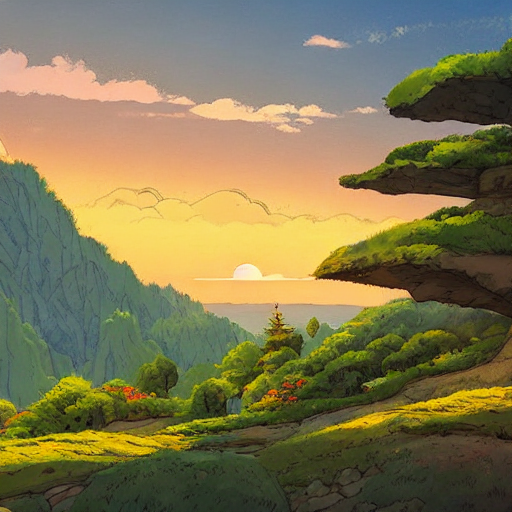

In [ ]:
sd_pipe_base = StableDiffusionPipeline.from_pretrained(config.pretrained_name,torch_dtype=torch.float16).to(device)
generate_image(sd_pipe_base, prompt, seed)

In [ ]:
sd_pipe_base.load_lora_weights('/content/output_dir/pytorch_lora_weights.safetensors')


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

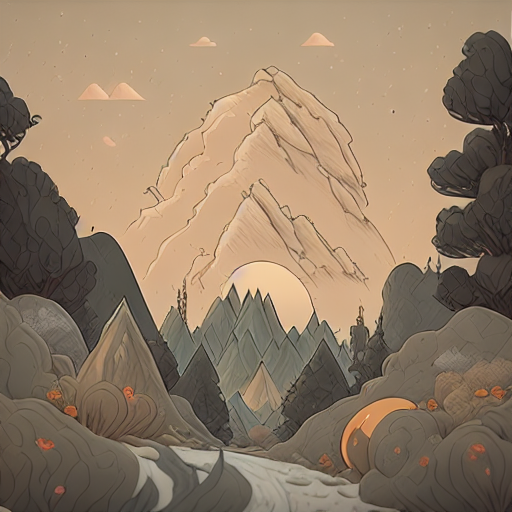

In [ ]:
generate_image(sd_pipe_base, prompt, seed)

In [ ]:
prompts = df['short_prompt']
prompt_list = prompts.tolist()
prompt_list[:4]

['A colorful robot braves the storm, sheltering under a vibrant umbrella.',
 'A portrait: Serene young woman with vibrant pink dreadlocks, against a deep purple backdrop.',
 'An intricate 3D sphere, red, with feather-like patterns, against a black backdrop.',
 "A warm and inspiring internal shot of an artist's studio."]

  0%|          | 0/50 [00:00<?, ?it/s]

A colorful robot braves the storm, sheltering under a vibrant umbrella.


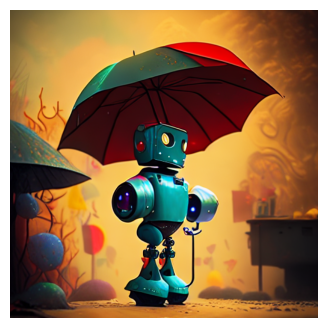

A portrait: Serene young woman with vibrant pink dreadlocks, against a deep purple backdrop.


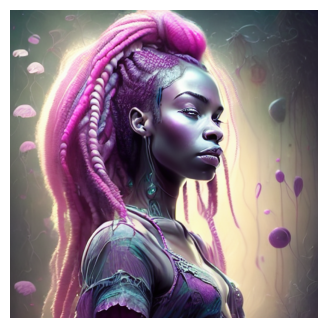

An intricate 3D sphere, red, with feather-like patterns, against a black backdrop.


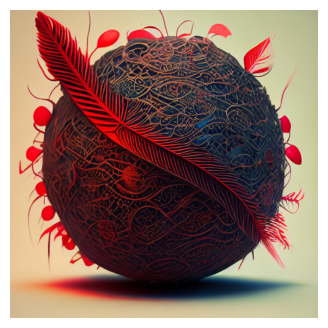

A warm and inspiring internal shot of an artist's studio.


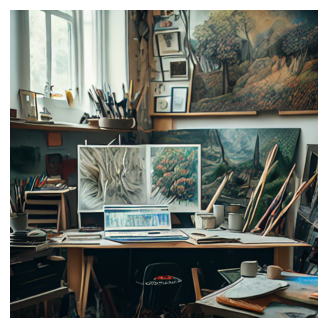

An ethereal, blue-hued throne room, focusing on a mysterious, hooded figure seated on intricate ice carvings.


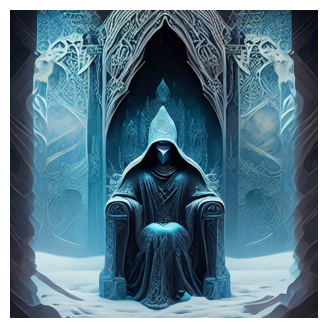


Saved 5 images to: generated_images


In [ ]:
import matplotlib.pyplot as plt

seed = 10
generator = torch.Generator("cuda" if torch.cuda.is_available() else "cpu").manual_seed(seed)
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

output = sd_pipe_base(prompt_list[:5], num_images_per_prompt=1, output_type="np",generator=generator)
images = output.images  # shape: (5, H, W, C)

for i, img_np in enumerate(images):
    img_uint8 = (img_np * 255).astype("uint8")
    img_pil = Image.fromarray(img_uint8)

    img_path = os.path.join(output_dir, f"image_{i+1}.png")
    img_pil.save(img_path)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_uint8)
    plt.axis("off")
    print(prompt_list[i])
    plt.show()

print(f"\nSaved {len(images)} images to: {output_dir}")


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 38.71 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.4 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [ ]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.1 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/segment-anything-2/generated_images/image_6.png


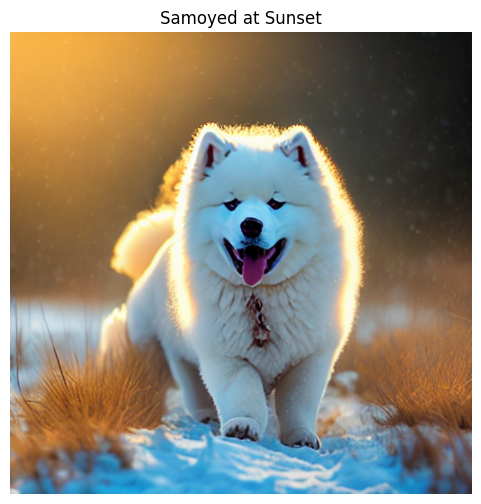

In [ ]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

prompt = "Samoyed playing in a snowy grass field at sunset"
seed = 42
generator = torch.Generator("cuda" if torch.cuda.is_available() else "cpu").manual_seed(seed)

image_np = sd_pipe_base(
    prompt=prompt,
    num_images_per_prompt=1,
    output_type="np",
    generator=generator
).images[0]

image_uint8 = (image_np * 255).astype("uint8")
image_pil = Image.fromarray(image_uint8)

output_dir = os.path.abspath("generated_images")
os.makedirs(output_dir, exist_ok=True)  # Ensure the folder exists
save_path = os.path.join(output_dir, "image_6.png")

image_pil.save(save_path)
print(f"Image saved to: {save_path}")

plt.figure(figsize=(6, 6))
plt.imshow(image_uint8)
plt.axis("off")
plt.title("Samoyed at Sunset")
plt.show()


In [ ]:
# Paths
input_folder = "/content/generated_images"
output_folder = "segmented_outputs"
os.makedirs(output_folder, exist_ok=True)

# Initialize SAM2 and annotator
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Get all input image paths
image_paths = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".png")])

# Process each image
for image_path in image_paths:
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate mask and annotate
    sam2_result = mask_generator.generate(image_rgb)
    detections = sv.Detections.from_sam(sam_result=sam2_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Concatenate original and annotated image horizontally
    combined_image = np.concatenate((image_bgr, annotated_image), axis=1)

    # Save the combined image
    save_path = os.path.join(output_folder, f"segmented_{os.path.basename(image_path)}")
    cv2.imwrite(save_path, combined_image)
    print(f"Saved segmented output: {save_path}")


Saved segmented output: segmented_outputs/segmented_image_1.png
Saved segmented output: segmented_outputs/segmented_image_2.png
Saved segmented output: segmented_outputs/segmented_image_3.png
Saved segmented output: segmented_outputs/segmented_image_4.png
Saved segmented output: segmented_outputs/segmented_image_5.png


In [ ]:
os.getcwd()

'/content/segment-anything-2'

In [ ]:

# Initialize SAM2 model and annotator
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Input and output paths
input_image_path = "/content/segment-anything-2/generated_images/image_6.png"
output_dir = "segmented_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load image
image_bgr = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Generate masks and annotate
sam2_result = mask_generator.generate(image_rgb)
detections = sv.Detections.from_sam(sam_result=sam2_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Concatenate original and annotated image
combined_image = np.concatenate((image_bgr, annotated_image), axis=1)

# Save combined image
output_path = os.path.join(output_dir, "segmented_image_6.png")
cv2.imwrite(output_path, combined_image)
print(f"Segmented image saved to: {output_path}")


Segmented image saved to: segmented_outputs/segmented_image_6.png


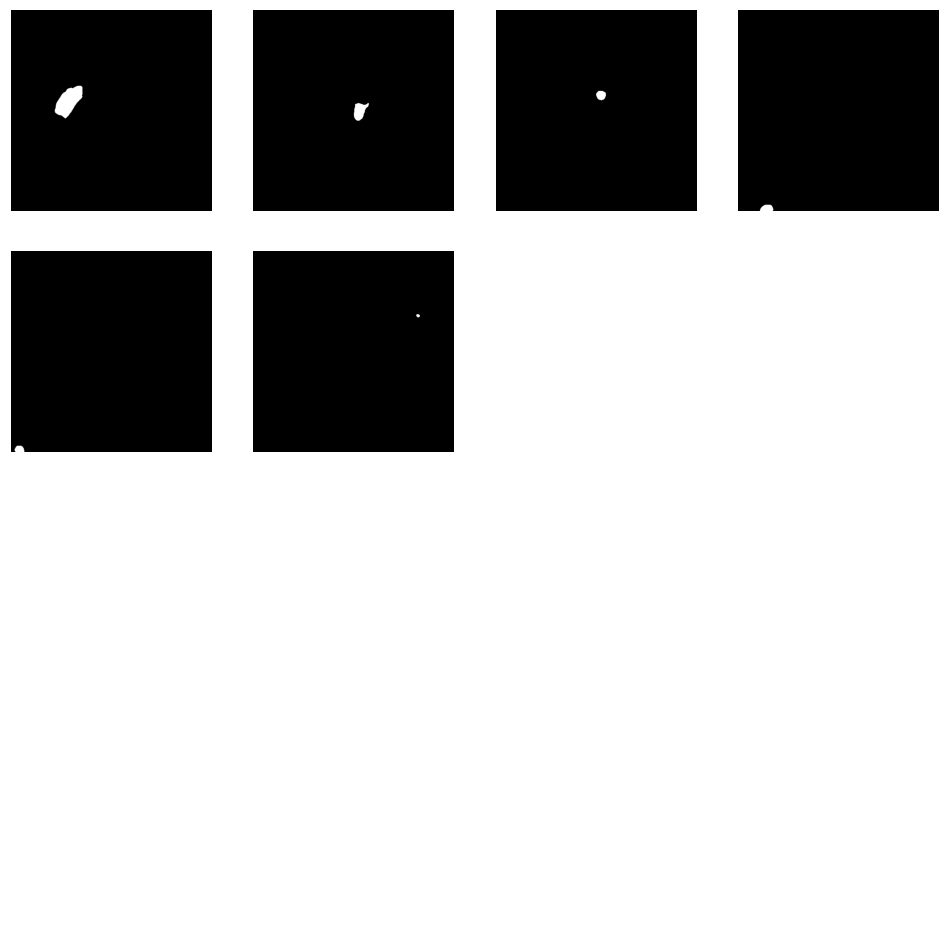

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

In [ ]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [ ]:
input_folder = "/content/generated_images"
output_folder = "/content/segment-anything-2/segmented_custom_outputs"
os.makedirs(output_folder, exist_ok=True)

image_paths = sorted([
    os.path.join(input_folder, f) for f in os.listdir(input_folder)
    if f.lower().endswith(".png")
])

for image_path in image_paths:
    filename = os.path.basename(image_path)
    print(f"Processing: {filename}")

    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    sam2_result = mask_generator_2.generate(image_rgb)
    detections = sv.Detections.from_sam(sam_result=sam2_result)
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    image_bgr_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    annotated_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_bgr_rgb)
    axs[0].set_title("Source Image")
    axs[0].axis("off")
    axs[1].imshow(annotated_rgb)
    axs[1].set_title("Segmented Image")
    axs[1].axis("off")

    save_path = os.path.join(output_folder, f"segmented_{filename}")
    fig.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

    print(f"✅ Saved to: {save_path}")


Processing: image_1.png
✅ Saved to: /content/segment-anything-2/segmented_custom_outputs/segmented_image_1.png
Processing: image_2.png
✅ Saved to: /content/segment-anything-2/segmented_custom_outputs/segmented_image_2.png
Processing: image_3.png
✅ Saved to: /content/segment-anything-2/segmented_custom_outputs/segmented_image_3.png
Processing: image_4.png
✅ Saved to: /content/segment-anything-2/segmented_custom_outputs/segmented_image_4.png
Processing: image_5.png
✅ Saved to: /content/segment-anything-2/segmented_custom_outputs/segmented_image_5.png


In [ ]:
import matplotlib.pyplot as plt

# --- Step 1: Extract masks ---
masks = [
    mask['segmentation']
    for mask in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

# --- Step 2: Create and save mask grid using matplotlib ---
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Top 16 SAM2 Masks", fontsize=16)

for i, ax in enumerate(axs.flat):
    if i < len(masks):
        ax.imshow(masks[i], cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")

# Save the mask grid
save_path = "/content/segment-anything-2/segmented_custom_outputs/image_6_mask_grid.png"
fig.savefig(save_path, bbox_inches="tight")
plt.close(fig)

print(f" Saved mask grid to: {save_path}")


 Saved mask grid to: /content/segment-anything-2/segmented_custom_outputs/image_6_mask_grid.png


In [ ]:
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
IMAGE_PATH = "/content/generated_images/image_4.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 89, 'y': 199, 'width': 272, 'height': 193, 'label': ''},
 {'x': 194, 'y': 4, 'width': 316, 'height': 173, 'label': ''}]

In [ ]:
default_box = widget.bboxes
boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

In [ ]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)


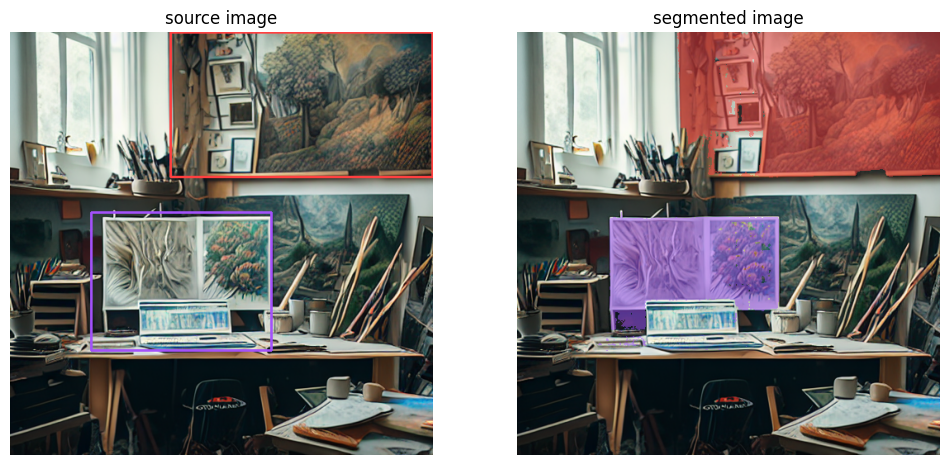

In [ ]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 110, 'y': 214, 'width': 236, 'height': 170, 'label': ''},
 {'x': 368, 'y': 171, 'width': 141, 'height': 206, 'label': ''},
 {'x': 4, 'y': 1, 'width': 121, 'height': 126, 'label': ''},
 {'x': 14, 'y': 132, 'width': 39, 'height': 59, 'label': ''},
 {'x': 230, 'y': 34, 'width': 72, 'height': 142, 'label': ''},
 {'x': 204, 'y': 418, 'width': 95, 'height': 88, 'label': ''}]

In [ ]:
default_box = widget.bboxes
boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

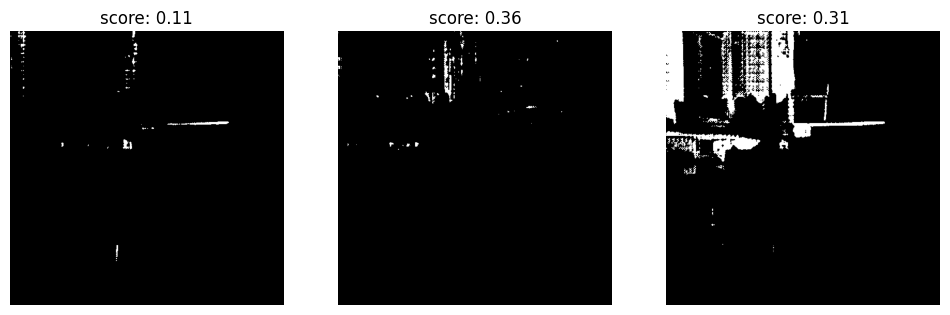

In [ ]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)